In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as x
from numba import njit
from tqdm import tqdm
import torch
import scipy


In [ ]:

N = 300
K = 7.5
n_r = 6
R = 2/3 * 10**6
C = 30 * 10**-12
V_r = -70 * 10**-3
theta = -50 * 10**-3  
w_e = 95 * 10**-12
w_in = 100#50 * 10**-12 #####
p_r = 0.25
tau_rp = 1 * 10**-3
tau_s = 5 * 10**-3
tau_R = 0.1



f = 5
dt = 0.0001
T = 1
time_steps = int(T / dt)

device = "cuda"

poisson_I= torch.tensor(np.random.poisson(f * dt, (N, time_steps)),device=device)

spikes = torch.zeros((N,time_steps),device=device)
U = torch.ones((N,time_steps,n_r),device=device)
V = torch.zeros(N,device=device)


Sleep = torch.zeros(N,device=device)
Switch = Sleep == 0




Graph = x.erdos_renyi_graph(N,K/N,seed=0,directed=False)
A = torch.zeros((N,N),device=device)
B = x.adjacency_matrix(Graph)
for edge in list(Graph.edges):
    A[edge[0],edge[1]] = +1


t_span = torch.tile(torch.arange(0,T,dt,device = device),(N,1))
def get_I_ext(t):
    I_ext = torch.zeros(N,device=device)
    step = int(t/dt)
    fired = torch.zeros((N,time_steps),device=device)
    fired[:,:step] = poisson_I[:,:step]
    return w_e * torch.sum((torch.exp((-(t - t_span*poisson_I)/tau_s) * fired) * fired),dim = 1)


def get_I_in(t,U,spikes):
    step = int(t/dt)
    opening = p_r * (U * spikes.reshape((N,time_steps,1)))
    eta = torch.rand(opening.shape,device=device)

    fired = torch.zeros((N,time_steps),device=device)
    fired[:,:step] = spikes[:,:step]
    gate = torch.sum(torch.exp((-(t - t_span*spikes)/tau_s) * fired) * fired * torch.heaviside(opening - eta ,torch.zeros_like(eta,device=device)).sum(2),dim = 1 )
    return w_in * A @  gate


def V_dot(V,t,U,spikes):
    return  -(V - V_r)/(R*C) + get_I_ext(t)/C + get_I_in(t,U,spikes)/C



def U_dot(t,U,spikes):
    U_dot = torch.zeros((N,6),device=device)
    step = int(t/dt)
    opening = spikes[:,step].reshape((-1,1))
    eta = torch.rand((N,n_r),device = device)
    U_dot = (1- U[:,step])/tau_R - ((torch.heaviside(p_r - eta ,torch.zeros_like(eta,device=device)) * opening) * U[:,step])
    return U_dot







for step in tqdm(range(time_steps-1)):
    Sleep -= ((Sleep > 0) * dt)
    Switch = Sleep < 0

    t = step * dt

    dU = U_dot(t,U,spikes)*dt
    dV = V_dot(V,t,U,spikes)*dt

    U[:,step+1,:] += dU

    V += dV * Switch

    is_spike = V > theta
    V[is_spike] = V_r
    U[is_spike,step+1] = 0
    spikes[:,step+1] =  is_spike

    Sleep += tau_rp * is_spike



# check index
# torch.save(spikes, "spikes.pt")


# files.download("spikes.pt")


100%|██████████| 9999/9999 [00:57<00:00, 174.68it/s]


num spikes :  tensor(42776.)


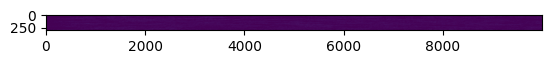

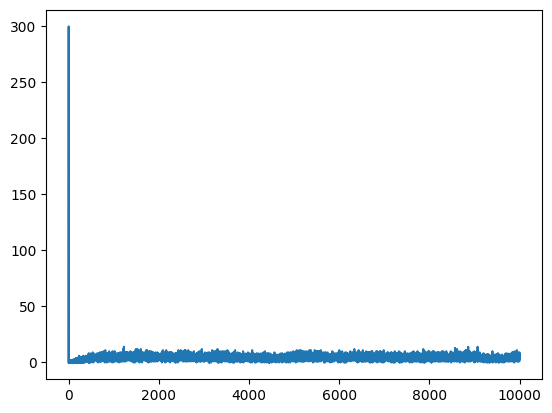

tensor(4.2776)
-0.8789587962867526


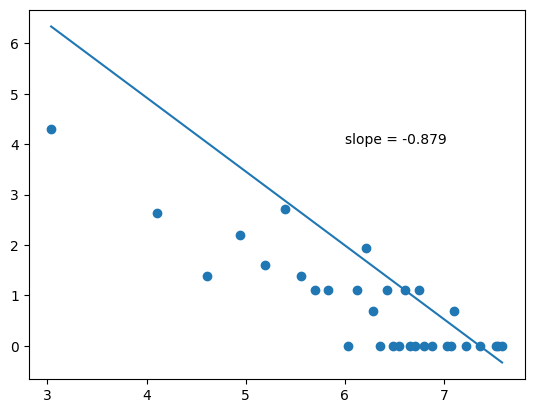

-0.9066025199239331


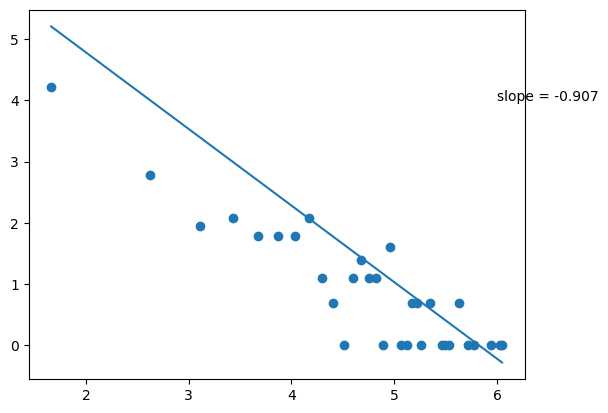

In [39]:



print("num spikes : ", torch.sum(spikes).cpu())

plt.imshow(spikes[:,:].cpu())
plt.show()
plt.plot(torch.arange(time_steps)[:],spikes.sum(0)[:].cpu())
plt.show()
print(spikes.sum(0).mean().cpu())



avalanch = spikes.sum(0) != 0
slippingR = avalanch.roll(+1)
slippingL = avalanch.roll(-1)
slippingR[0] = False
slippingL[-1] = False

ends  = torch.logical_xor( avalanch ,(avalanch *slippingL))
starts  = torch.logical_xor( avalanch ,(avalanch *slippingR))

spikes_sum = torch.cumsum(spikes.sum(dim = 0),dim = 0)

avalanches_size = spikes_sum[torch.where(ends)[0]] - spikes_sum[torch.where(starts)[0]] + 1

# nbins = 10
# bins = np.exp(np.linspace(np.log(avalanches_size.cpu().min()), np.log(avalanches_size.cpu().max()) , nbins))
bins = 50
freq,size = np.histogram(avalanches_size.cpu(),bins = bins)
size = (size[:-1] + size[1:])/2

slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[freq != 0]),np.log(freq[freq != 0]))
print(slope)

plt.scatter(np.log(size[freq != 0]),np.log(freq[freq != 0]))
plt.plot([np.log(size[freq != 0])[0],np.log(size[freq != 0][-1])],[intercept,intercept + slope * np.log(size[freq != 0][-1])])
plt.text(6,4,f"slope = {np.round(slope,3)}")
plt.show()

avalanches_steps = torch.where(ends) [0] -   torch.where(starts)[0] + 1


# nbins = 10
# bins = np.exp(np.linspace(np.log(avalanches_size.cpu().min()), np.log(avalanches_size.cpu().max()) , nbins))
bins = 50
freq,size = np.histogram(avalanches_steps.cpu(),bins = 50)
size = (size[:-1] + size[1:])/2


slope , intercept, rvalue ,_,_= scipy.stats.linregress(np.log(size[freq != 0]),np.log(freq[freq != 0]))
print(slope)


plt.scatter(np.log(size[freq != 0]),np.log(freq[freq != 0]))
plt.plot([np.log(size[freq != 0])[0],np.log(size[freq != 0][-1])],[intercept,intercept + slope * np.log(size[freq != 0][-1])])
plt.text(6,4,f"slope = {np.round(slope,3)}")
plt.show()
